# Test for Data preprocessing steps # 

This preprocessing steps where tested on swarming Data collected by Surabhi, but slight modifications have been aplied to data sets including a smaler number of nematodes

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from skimage.morphology import skeletonize
from scipy.ndimage import label

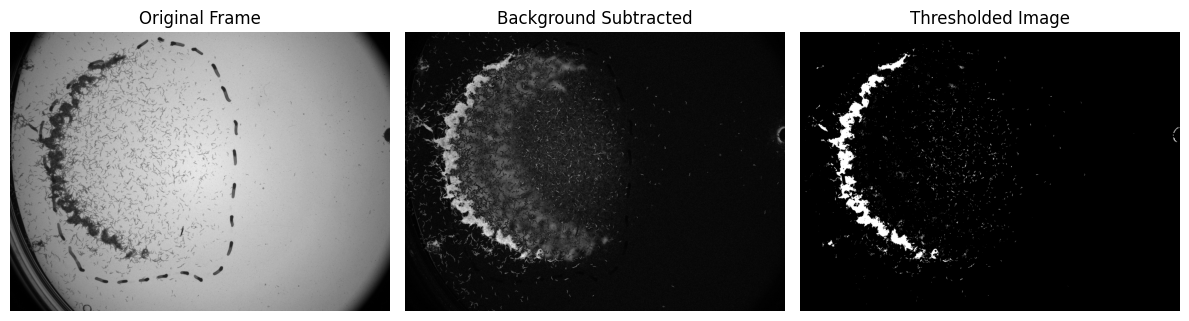

In [22]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import random

def load_and_average_frames(frame_dir, n=50):
    # List all frame files
    frame_files = [os.path.join(frame_dir, f) for f in os.listdir(frame_dir) if f.endswith('.tif') and not f.startswith('._')]
    
    # Randomly sample n frames (or use all if there are less than n)
    sampled_frame_files = random.sample(frame_files, min(n, len(frame_files)))

    # Load and accumulate the frames
    avg_frame = None
    for file in sampled_frame_files:
        img = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
        if img is None:
            raise IOError(f"Could not load image {file}")
        if avg_frame is None:
            avg_frame = np.zeros_like(img, dtype=np.float64)
        avg_frame += img / n

    return avg_frame.astype(np.uint8), frame_files

def subtract_background_and_threshold(frame_file, background_avg, threshold_value=29):
    # Load the target frame
    frame = cv2.imread(frame_file, cv2.IMREAD_GRAYSCALE)
    if frame is None:
        raise IOError("Could not load the target frame.")

    # Background subtraction
    background_subtracted = cv2.absdiff(frame, background_avg)

    # Thresholding
    _, thresholded = cv2.threshold(background_subtracted, threshold_value, 255, cv2.THRESH_BINARY)

    return frame, background_subtracted, thresholded

# Directory containing frames
frame_dir = '/Volumes/TOSHIBA_EXT/swarming_surabhi/Experiment-589/Experiment-589'

# Load and average frames for background
background_avg, frame_files = load_and_average_frames(frame_dir)

# Choose a frame index k
k = 8000  # Update this to your chosen frame index

# Ensure k is within the range of available frames
if k >= len(frame_files):
    raise ValueError(f"Frame index k={k} is out of range. Only {len(frame_files)} frames are available.")

# Apply background subtraction and thresholding to the kth frame
original_frame, background_subtracted, thresholded = subtract_background_and_threshold(frame_files[k], background_avg)

# Plot the results
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(original_frame, cmap='gray')
plt.title('Original Frame')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(background_subtracted, cmap='gray')
plt.title('Background Subtracted')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(thresholded, cmap='gray')
plt.title('Thresholded Image')
plt.axis('off')

plt.tight_layout()
plt.show()


## Apply to all frames and reconstruct video ## 

In [26]:
import cv2
import numpy as np
import os
import random

def load_and_average_frames(frame_dir, n=50):
    frame_files = [os.path.join(frame_dir, f) for f in os.listdir(frame_dir) if f.endswith('.tif') and not f.startswith('._')]
    sampled_frame_files = random.sample(frame_files, min(n, len(frame_files)))
    avg_frame = None
    for file in sampled_frame_files:
        img = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
        if img is None:
            raise IOError(f"Could not load image {file}")
        if avg_frame is None:
            avg_frame = np.zeros_like(img, dtype=np.float64)
        avg_frame += img / n
    return avg_frame.astype(np.uint8), frame_files

def process_and_save_frames(frame_files, background_avg, output_dir, threshold_value=29):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for i, frame_file in enumerate(frame_files):
        frame = cv2.imread(frame_file, cv2.IMREAD_GRAYSCALE)
        if frame is None:
            continue
        background_subtracted = cv2.absdiff(frame, background_avg)
        _, thresholded = cv2.threshold(background_subtracted, threshold_value, 255, cv2.THRESH_BINARY)
        
        output_file = os.path.join(output_dir, f'frame_{i:05d}.jpg')
        cv2.imwrite(output_file, thresholded)

# Paths
input_frame_dir = '/Volumes/TOSHIBA_EXT/swarming_surabhi/Experiment-589/Experiment-589'
output_frame_dir = '/Volumes/TOSHIBA_EXT/swarming_surabhi/Experiment-589/preprocessed_frames'

# Create background model and get frame paths
background_avg, frame_files = load_and_average_frames(input_frame_dir)

# Process and save frames
process_and_save_frames(frame_files, background_avg, output_frame_dir)


In [27]:
def create_video_from_frames(frame_folder, output_video_file, frame_rate=30):
    frame_files = sorted([os.path.join(frame_folder, f) for f in os.listdir(frame_folder) if f.endswith('.jpg')])
    
    # Get size of the first frame
    first_frame = cv2.imread(frame_files[0])
    height, width, layers = first_frame.shape
    size = (width, height)

    out = cv2.VideoWriter(output_video_file, cv2.VideoWriter_fourcc(*'mp4v'), frame_rate, size)

    for frame_file in frame_files:
        frame = cv2.imread(frame_file)
        if frame is None:
            continue
        out.write(frame)
    
    out.release()

output_video_file = '/Volumes/TOSHIBA_EXT/swarming_surabhi/Experiment-589/processed_video.mp4'
create_video_from_frames(output_frame_dir, output_video_file)

AttributeError: 'NoneType' object has no attribute 'shape'

## Fit network to image ##

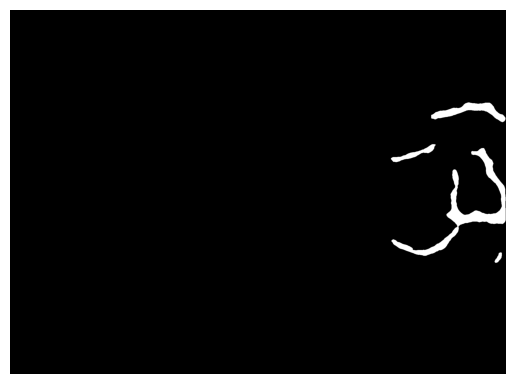

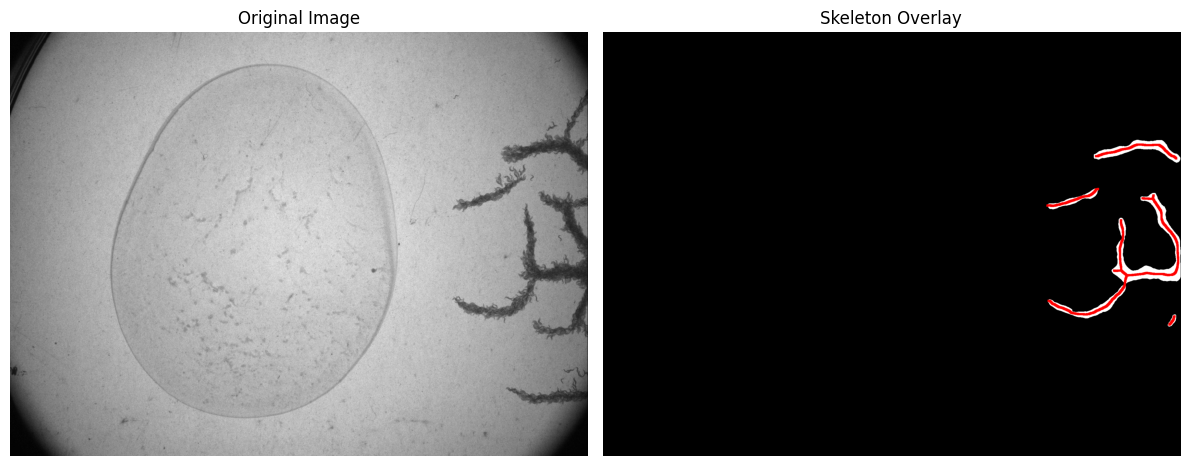

In [13]:
from skimage.morphology import dilation, square

# Apply Median Filter
# The argument to the function is the size of the kernel. Here it's set to 5.
median_smoothed_image = cv2.medianBlur(lightest_pixels, 29)

# Skeletonize the image to get the center line of white pixels
# Skeletonize the smoothed image
skeleton = skeletonize(median_smoothed_image // 255).astype(np.uint8)

# Increase the thickness of the skeleton
thick_skeleton = dilation(skeleton, square(8))  # Adjust the size for thicker lines as needed

# Convert the median smoothed image to BGR before overlaying the thick skeleton
thick_overlay_image = cv2.cvtColor(median_smoothed_image, cv2.COLOR_GRAY2BGR)
thick_overlay_image[thick_skeleton == 1] = [255, 0, 0]  # Red color for the skeleton

# Plot the frame with the lightest pixels
plt.imshow(median_smoothed_image, cmap='gray')
# plt.title('Smoothed Image')
plt.axis('off')
plt.show()

# Display the images
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(background_frames[0], cmap='gray')
axes[0].set_title('Original Image')
axes[1].imshow(thick_overlay_image)
axes[1].set_title('Skeleton Overlay')
for ax in axes:
    ax.axis('off')
plt.tight_layout()
plt.show()


## detect nodes and end nodes on the skeleton ##

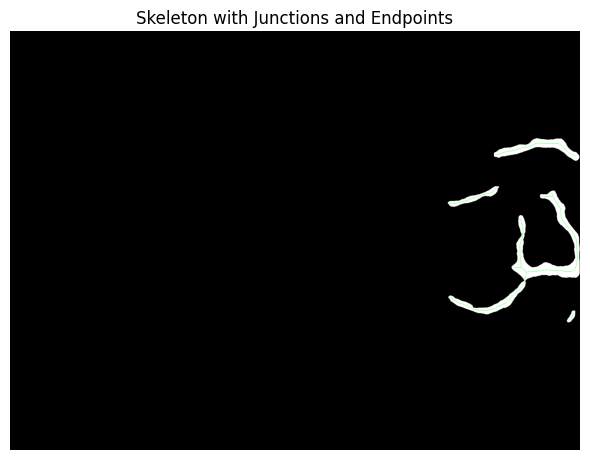

In [17]:
from skimage.morphology import skeletonize, dilation, square
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Now we proceed to detect junctions and endpoints in the skeleton
# Create a kernel for detecting the neighbors
# A pixel must be white and have exactly one white neighbor to be an endpoint
# A pixel must be white and have more than two white neighbors to be a junction
kernel = np.array([[1,  1, 1],
                   [1, 10, 1],
                   [1,  1, 1]], dtype=np.uint8)

# Filter the skeleton with the kernel
filtered = cv2.filter2D(skeleton, -1, kernel)

# Now, detect the junctions and endpoints based on the convoluted image
junctions = np.where(filtered > 11, 1, 0)
endpoints = np.where(filtered == 11, 1, 0)

# Increase the thickness of the skeleton for visualization purposes
thick_skeleton = dilation(skeleton, square(6))  # Adjust the size for thicker lines as needed

# Convert the median smoothed image to BGR before overlaying the skeleton
overlay_image = cv2.cvtColor(median_smoothed_image, cv2.COLOR_GRAY2BGR)
# overlay_image[thick_skeleton == 1] = [255, 0, 255]  # Red color for the skeleton
overlay_image[junctions == 1] = [0, 255, 0]  # Green color for junctions
# overlay_image[endpoints == 1] = [0, 0,255]  # Blue color for endpoints

# Display the images
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(overlay_image)
ax.set_title('Skeleton with Junctions and Endpoints')
ax.axis('off')
plt.tight_layout()
plt.show()
